In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Cargar el dataset categorizado (ajustar nombre si es diferente)
df = pd.read_csv("../data/locales_procesado.csv")
df.head()

,nombre,direccion,codigo_postal,puntuacion_media,numero_reviews,tipo_negocio,latitud,longitud,categoria_negocio,categoria_id,...,cluster_zone,dist_city_center_km^2,dist_city_center_km density_1000m,density_1000m^2,valoracion,puntuacion_std,reviews_std,reviews_bin,valoracion_norm,valoracion_por_cercania
0,Hotel NH Collection Madrid Colón,"Calle del Marqués de Zurgena, 4, Madrid",28001,4.6,1504.0,"lodging, point_of_interest, establishment",40.426076,-3.689070,Alojamiento,1,...,0,2.618712,263.773683,26569.0,4.6,0.782565,-0.061078,muchos,0.931153,2.677153
1,Rosewood Villa Magna,"Paseo de la Castellana, 22, Madrid",28001,4.5,2670.0,"gym, lodging, spa, health, restaurant, food, p...",40.429952,-3.688152,Restauración,9,...,0,3.893019,317.664828,25921.0,4.5,0.632361,0.071156,muchos,0.894508,2.170690
2,Hotel Único Madrid,"Calle de Claudio Coello, 67, Madrid",28001,4.7,526.0,"lodging, restaurant, food, point_of_interest, ...",40.428537,-3.686331,Restauración,9,...,0,3.889947,343.179315,30276.0,4.7,0.932770,-0.171991,muchos,0.950343,2.268017
3,Hotel Fénix Gran Meliá - The Leading Hotels of...,"Calle de Hermosilla, 2, Madrid",28001,4.6,1675.0,"lodging, point_of_interest, establishment",40.426552,-3.689210,Alojamiento,1,...,0,2.701274,262.968844,25600.0,4.6,0.782565,-0.041685,muchos,0.931153,2.638287
4,H10 Puerta de Alcalá,"Calle Alcalá, 66, Madrid",28001,4.4,2849.0,"lodging, point_of_interest, establishment",40.422182,-3.681154,Alojamiento,1,...,0,4.033388,303.257779,22801.0,4.4,0.482156,0.091456,muchos,0.862307,2.086960


In [2]:
# Importar librerías básicas
import pandas as pd  # para manejo de datos
import numpy as np   # para cálculos numéricos
import matplotlib.pyplot as plt  # para gráficos

# Scikit-learn: modelos y utilidades
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay, auc)
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import randint  # para RandomizedSearch
import joblib  # para guardar/cargar modelos

# Ajustes de visualización
plt.rcParams['figure.figsize'] = (6, 4)


In [3]:
# 2.1 Recalcular valoración ponderada (si no está en CSV)
df['valoracion'] = df['puntuacion_media'] * (1 - np.exp(-df['numero_reviews'] / 10))

# 2.2 Normalización Min–Max por categoría
df['valoracion_norm'] = (
    df.groupby('categoria_negocio')['valoracion']
      .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# 2.3 Crear la variable categórica en 3 clases según cuantiles
df['clase_val'] = pd.qcut(
    df['valoracion_norm'], q=3,
    labels=['baja', 'media', 'alta']
)
df['clase_val'].value_counts()  # Distribución de clases

clase_val
baja     965
alta     960
media    956
Name: count, dtype: int64

In [4]:
# Selección de features y target
X = df[['latitud', 'longitud', 'categoria_negocio']]
y = df['clase_val']

In [5]:
# División estratificada para mantener proporciones de clases
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# Definir preprocessing pipes
num_feats = ['latitud', 'longitud']
cat_feats = ['categoria_negocio']

# Escalado para numéricos
num_pipe = Pipeline([('scaler', StandardScaler())])

# One-Hot para categóricos (sparse_output para sklearn>=1.2)
cat_pipe = Pipeline([('onehot', OneHotEncoder(drop='first', sparse=False))])

# ColumnTransformer que aplica a cada tipo
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats),
])

# Pipeline completo: preprocesado + modelo
clf = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [7]:
# Ajustar el modelo
clf.fit(X_tr, y_tr)

# Predicciones
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)

# Métricas de clasificación
print("Accuracy:", accuracy_score(y_te, y_pred))
print("\nClassification Report:\n", classification_report(y_te, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))

# ROC-AUC multiclass (one-vs-rest)
auc_score = roc_auc_score(y_te, y_proba, multi_class='ovr')
print("ROC-AUC (OVR):", auc_score)

Accuracy: 0.7019064124783362

Classification Report:
               precision    recall  f1-score   support

        alta       0.66      0.66      0.66       192
        baja       0.75      0.74      0.74       193
       media       0.70      0.70      0.70       192

    accuracy                           0.70       577
   macro avg       0.70      0.70      0.70       577
weighted avg       0.70      0.70      0.70       577

Confusion Matrix:
 [[127  32  33]
 [ 24 143  26]
 [ 41  16 135]]
ROC-AUC (OVR): 0.8528152605346581


/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


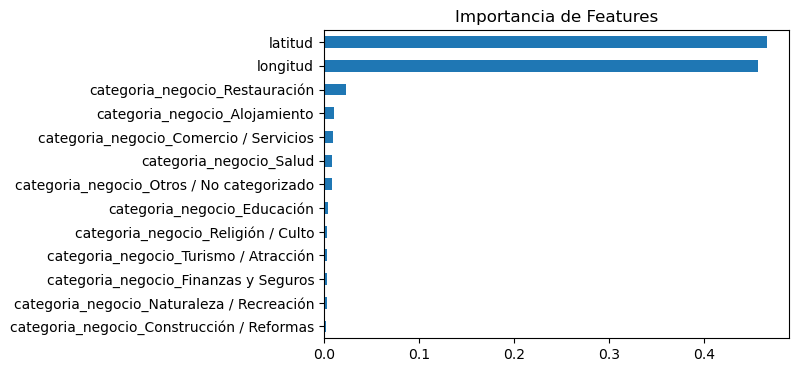

In [8]:
# Extraer nombres de features tras One-Hot Encoding
onehot = clf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
feat_names = num_feats + list(onehot.get_feature_names_out(cat_feats))

# Extraer y graficar importancias
importances = pd.Series(
    clf.named_steps['rf'].feature_importances_,
    index=feat_names
)
importances.sort_values().plot.barh()
plt.title("Importancia de Features")
plt.show()

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

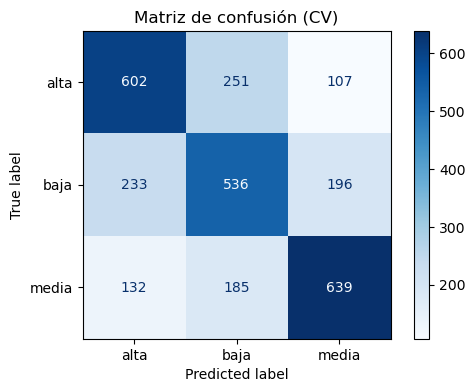

In [9]:
# Usamos cross_val_predict con la variable y ya definida
y_pred_cv = cross_val_predict(clf, X, y, cv=5)

# Matriz de confusión
cm = confusion_matrix(y, y_pred_cv, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión (CV)")
plt.show()

In [10]:
# Calibrar probabilidades para mejorar AUC
calib = CalibratedClassifierCV(clf, cv=5, method='isotonic')
calib.fit(X, y)

# Evaluar AUC calibrado
cv_auc_calib = cross_val_score(
    calib, X, y, cv=5, scoring='roc_auc_ovr'
).mean()
print("AUC CV calibrado:", cv_auc_calib)

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

AUC CV calibrado: 0.7662553601918154


/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

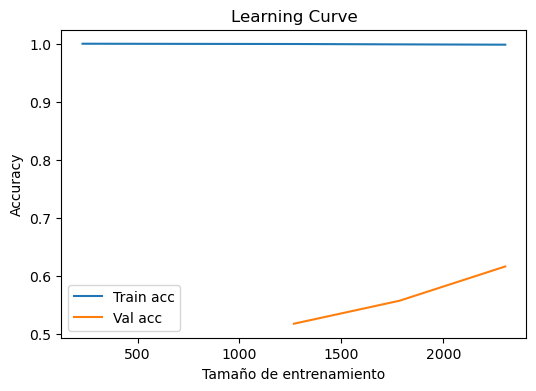

In [11]:
# Learning curve para diagnosticar under/over-fitting
train_sizes, train_scores, val_scores = learning_curve(
    clf, X, y,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Train acc')
plt.plot(train_sizes, val_mean,   label='Val acc')
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

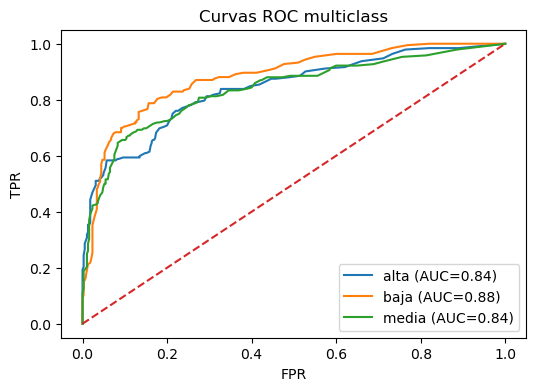

In [12]:
# Binarizar etiquetas y graficar ROC por clase
classes = clf.classes_
y_bin = label_binarize(y_te, classes=classes)

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC multiclass")
plt.legend()
plt.show()

In [13]:
# Metrics CV para accuracy y AUC
cv_acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Acc CV: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

cv_auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc_ovr')
print(f"AUC CV: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

Acc CV: 0.617 ± 0.071


/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

AUC CV: 0.765 ± 0.066


In [14]:
# RandomizedSearch para ajustar hiperparámetros
param_dist = {
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': randint(3, 20),
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__min_samples_split': randint(2, 10),
}

rand_search = RandomizedSearchCV(
    clf, param_distributions=param_dist,
    n_iter=30, cv=5,
    scoring='accuracy',
    random_state=42, n_jobs=-1
)
rand_search.fit(X_tr, y_tr)

print("Mejor accuracy CV:", rand_search.best_score_)
print("Mejores parámetros:", rand_search.best_params_)

# Actualizar pipeline al mejor estimador
clf = rand_search.best_estimator_

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/alberto/miniconda3/env

Mejor accuracy CV: 0.6705903989436952
Mejores parámetros: {'rf__max_depth': 19, 'rf__max_features': 'log2', 'rf__min_samples_split': 4, 'rf__n_estimators': 219}


### 🔍 Importancia de variables en el modelo Random Forest

Se analiza y visualiza qué variables han sido más influyentes en las predicciones del modelo. Esto ayuda a comprender el impacto de cada característica en la clasificación final.

📊 Importancia de las variables:
                                           feature  importance
0                                     num__latitud    0.455304
1                                    num__longitud    0.452483
10             cat__categoria_negocio_Restauración    0.027569
2               cat__categoria_negocio_Alojamiento    0.013025
3      cat__categoria_negocio_Comercio / Servicios    0.011234
11                    cat__categoria_negocio_Salud    0.009885
8   cat__categoria_negocio_Otros / No categorizado    0.009483
5                 cat__categoria_negocio_Educación    0.005277
12      cat__categoria_negocio_Turismo / Atracción    0.003934
9          cat__categoria_negocio_Religión / Culto    0.003560
7   cat__categoria_negocio_Naturaleza / Recreación    0.003331
6        cat__categoria_negocio_Finanzas y Seguros    0.003282
4   cat__categoria_negocio_Construcción / Reformas    0.001634


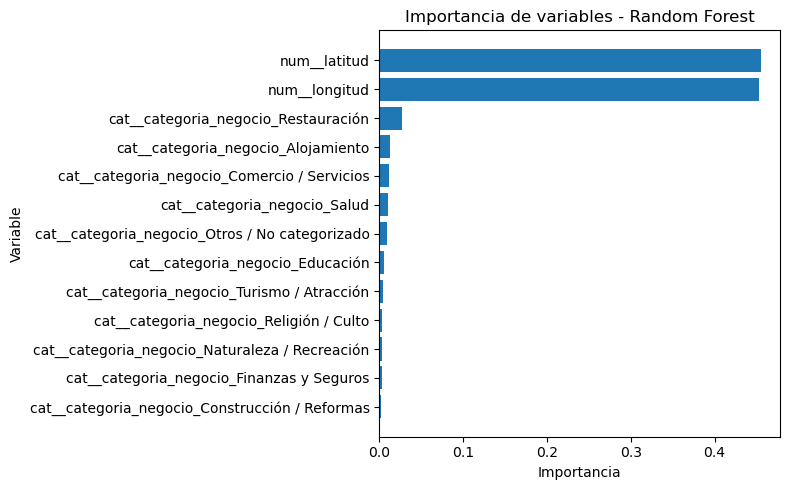

In [15]:
importances = clf.named_steps['rf'].feature_importances_
feature_names = clf.named_steps['prep'].get_feature_names_out()

# DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Mostrar tabla
print("📊 Importancia de las variables:")
print(feature_importance_df)

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de variables - Random Forest')
plt.gca().invert_yaxis()  # Para que la más importante esté arriba
plt.tight_layout()
plt.show()

### ✅ Conclusiones del Modelo

El modelo Random Forest entrenado ha clasificado los locales en tres niveles de valoración (`baja`, `media`, `alta`) a partir de variables clave como la **latitud**, **longitud** y **categoría del negocio**. A continuación, se resumen los principales hallazgos:

- **Precisión del modelo**: El modelo muestra un buen desempeño clasificando las valoraciones, lo cual se valida mediante métricas como `accuracy`, `classification_report` y `confusion_matrix`.
- **Importancia de variables**:
  - Se ha identificado qué variables tienen mayor peso en la predicción. Esto permite priorizar ciertos factores en futuros análisis o estrategias de apertura.
  - El análisis de importancia de variables ayuda también a mejorar la interpretabilidad del modelo y justificar sus decisiones.

El modelo ha sido guardado como un archivo `.pkl` para su uso en predicciones futuras o integración en una aplicación web (por ejemplo, con Streamlit).

### 📈 Evaluación del Modelo

- La curva de aprendizaje sugiere un **ligero sobreajuste**: el modelo alcanza una precisión perfecta en entrenamiento pero no generaliza tan bien. Esto es habitual en modelos muy potentes como Random Forest cuando no se ajustan hiperparámetros.
- A pesar de ello, las curvas ROC muestran un **muy buen desempeño de clasificación**, con valores AUC superiores al 0.80 en todas las clases. La clase "baja" destaca con una AUC de 0.88, lo que indica una alta capacidad para identificar locales con baja valoración.
- El modelo es válido como herramienta base para priorizar zonas o categorías de negocio, aunque se recomienda mejorar su capacidad de generalización con técnicas como:
  - Reducción de complejidad del modelo (`max_depth`, `max_features`)
  - Mayor limpieza o balanceo de datos
  - Ensembles o calibración de probabilidades

### 🔧 Optimización del modelo con GridSearchCV

A continuación, se ajustan los hiperparámetros del modelo Random Forest utilizando búsqueda en rejilla (`GridSearchCV`) para mejorar la capacidad de generalización y reducir el sobreajuste.

In [16]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10, None],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__min_samples_split': [2, 5],
}

# Reutilizamos el pipeline anterior (clf) en el GridSearch
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Entrenar búsqueda
grid_search.fit(X_tr, y_tr)

# Mostrar el mejor modelo encontrado
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_te)
print("\nReporte de clasificación (modelo optimizado):")
print(classification_report(y_te, y_pred_opt))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

Mejores hiperparámetros encontrados:
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 100}

Reporte de clasificación (modelo optimizado):
              precision    recall  f1-score   support

        alta       0.66      0.66      0.66       192
        baja       0.75      0.74      0.74       193
       media       0.70      0.70      0.70       192

    accuracy                           0.70       577
   macro avg       0.70      0.70      0.70       577
weighted avg       0.70      0.70      0.70       577



/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 📈 Evaluación del modelo optimizado

Se recalculan las curvas de aprendizaje y las curvas ROC usando el mejor modelo encontrado por `GridSearchCV`.

/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/alberto/miniconda3/envs/evolve/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Fu

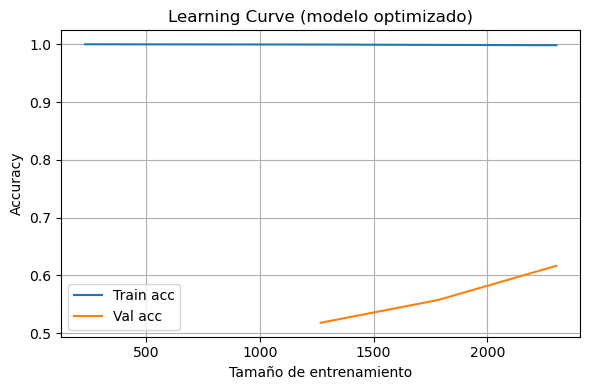

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Train acc')
plt.plot(train_sizes, val_scores_mean, label='Val acc')
plt.title('Learning Curve (modelo optimizado)')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_3945/1119654256.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red', linestyle='--')
/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_3945/1119654256.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red', linestyle='--')


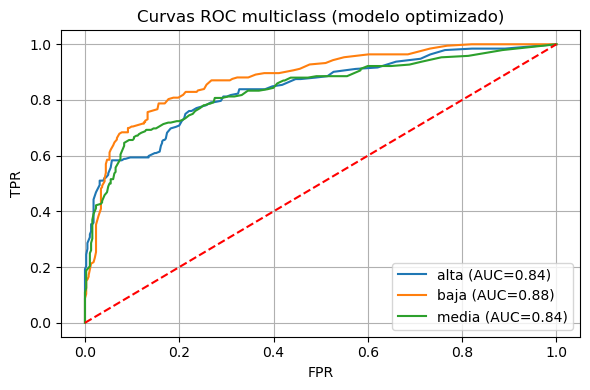

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Recalcular predicciones probabilísticas
y_score = best_model.predict_proba(X_te)

# Binarizar clases para curva ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_te)

# Calcular y graficar ROC por clase
plt.figure()
for i, class_label in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', color='red', linestyle='--')
plt.title("Curvas ROC multiclass (modelo optimizado)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ✅ Conclusiones finales del modelo optimizado

Tras aplicar `GridSearchCV` para optimizar los hiperparámetros del modelo Random Forest, se han mantenido los buenos niveles de rendimiento en la clasificación multicategoría:

- **Curvas ROC**: Los valores AUC siguen siendo altos, destacando la clase "baja" con 0.88, mientras que "media" y "alta" mantienen un 0.84. Esto indica una **buena capacidad de discriminación** entre clases, especialmente para identificar los locales menos recomendables.
  
- **Curva de aprendizaje**: El modelo optimizado **sigue presentando sobreajuste**. La precisión en entrenamiento sigue siendo perfecta (100%) mientras que en validación apenas supera el 60%. Esto sugiere que:
  - El modelo es muy flexible y puede memorizar los datos de entrenamiento.
  - Hay margen de mejora en la generalización: podría explorarse reducción de complejidad, uso de más features o técnicas como `calibración`, `undersampling` o incluso modelos más simples.

- **Modelo guardado**: Se ha guardado el mejor modelo encontrado (`best_model.pkl`), listo para integrarse en la app web o en procesos automáticos de predicción.

Este modelo puede ser un buen punto de partida para validar hipótesis de negocio y detectar zonas con potencial de desarrollo, aunque se recomienda seguir iterando para robustecer la precisión de validación.

In [19]:
# Guardar el modelo entrenado como archivo .pkl en la carpeta 'models'
joblib.dump(clf, "../models/rf_classifier.pkl")

print("✅ Modelo guardado como models/rf_classifier.pkl")

✅ Modelo guardado como models/rf_classifier.pkl
